In [ ]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
df_identity = pd.read_csv('/content/data_identification.csv')
df_emotion = pd.read_csv('/content/emotion.csv')
df_tweet = pd.read_json('/content/tweets_DM.json', lines=True)

In [ ]:
df_tweet_source = df_tweet[['_source']]
print(df_tweet_source.head())

                                             _source
0  {'tweet': {'hashtags': ['Snapchat'], 'tweet_id...
1  {'tweet': {'hashtags': ['freepress', 'TrumpLeg...
2  {'tweet': {'hashtags': ['bibleverse'], 'tweet_...
3  {'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...
4  {'tweet': {'hashtags': [], 'tweet_id': '0x2de2...


In [ ]:
df_tweet['_source_str'] = df_tweet['_source'].apply(str)
df_tweet['_source_split'] = df_tweet['_source_str'].apply(lambda x: x.split(','))
print(df_tweet[['_source_split']].head())

                                       _source_split
0  [{'tweet': {'hashtags': ['Snapchat'],  'tweet_...
1  [{'tweet': {'hashtags': ['freepress',  'TrumpL...
2  [{'tweet': {'hashtags': ['bibleverse'],  'twee...
3  [{'tweet': {'hashtags': [],  'tweet_id': '0x1c...
4  [{'tweet': {'hashtags': [],  'tweet_id': '0x2d...


In [ ]:
df_tweet['_source_cleaned'] = df_tweet['_source_str'].apply(lambda x: x.split(',', 1)[-1] if ',' in x else x)
print(df_tweet[['_source_cleaned']].head(20))

                                      _source_cleaned
0    'tweet_id': '0x376b20', 'text': 'People who p...
1    'TrumpLegacy', 'CNN'], 'tweet_id': '0x2d5350'...
2    'tweet_id': '0x28b412', 'text': 'Confident of...
3    'tweet_id': '0x1cd5b0', 'text': 'Now ISSA is ...
4    'tweet_id': '0x2de201', 'text': '"Trust is no...
5    'LaughOutLoud'], 'tweet_id': '0x1d755c', 'tex...
6    'tweet_id': '0x2c91a8', 'text': 'Still waitin...
7    'tweet_id': '0x368e95', 'text': 'Love knows n...
8    'tweet_id': '0x249c0c', 'text': '@DStvNgCare ...
9    'money', 'possessions'], 'tweet_id': '0x21844...
10   'gender', 'diversity'], 'tweet_id': '0x359db9...
11   'tweet_id': '0x23b037', 'text': "I love suffe...
12   'tweet_id': '0x1fde89', 'text': 'Can someone ...
13   'ecology'], 'tweet_id': '0x37a0a9', 'text': '...
14   'tweet_id': '0x269112', 'text': "My brother d...
15   'tweet_id': '0x360665', 'text': 'On a scale o...
16   'evatech', 'bendingcomposite', 'inovarsandton...
17   'tweet_id': '0x25be54',

In [ ]:
import re

def extract_tweet_info(source_str):
    # Regular expression to find 'tweet_id' and 'text' and their values
    tweet_id_match = re.search(r"'tweet_id':\s*'([^']*)'", source_str)
    text_match = re.search(r"'text':\s*'([^']*)'", source_str)

    # Extract 'tweet_id' and 'text' if found
    tweet_id = tweet_id_match.group(0) if tweet_id_match else None
    text = text_match.group(0) if text_match else None

    # Combine the results (only if both are found)
    return ', '.join(filter(None, [tweet_id, text]))

# Apply the function to the '_source' column
df_tweet['_source_cleaned'] = df_tweet['_source_str'].apply(extract_tweet_info)

# Display the first few rows with the cleaned data
print(df_tweet[['_source_cleaned']].head())

                                     _source_cleaned
0  'tweet_id': '0x376b20', 'text': 'People who po...
1  'tweet_id': '0x2d5350', 'text': '@brianklaas A...
2  'tweet_id': '0x28b412', 'text': 'Confident of ...
3  'tweet_id': '0x1cd5b0', 'text': 'Now ISSA is s...
4  'tweet_id': '0x2de201', 'text': '"Trust is not...


In [ ]:
# Extract tweet_id and text into separate columns using regular expressions
df_tweet['tweet_id'] = df_tweet['_source_cleaned'].apply(lambda x: re.search(r"'tweet_id':\s*'([^']*)'", x).group(1) if re.search(r"'tweet_id':\s*'([^']*)'", x) else None)
df_tweet['text'] = df_tweet['_source_cleaned'].apply(lambda x: re.search(r"'text':\s*'([^']*)'", x).group(1) if re.search(r"'text':\s*'([^']*)'", x) else None)
df_tweet = df_tweet.drop(columns=['_source'])

# Display the first few rows to verify the result
print(df_tweet[['tweet_id', 'text']].head())

   tweet_id                                               text
0  0x376b20  People who post "add me on #Snapchat" must be ...
1  0x2d5350  @brianklaas As we see, Trump is dangerous to #...
2  0x28b412  Confident of your obedience, I write to you, k...
3  0x1cd5b0                Now ISSA is stalking Tasha 😂😂😂 <LH>
4  0x2de201  "Trust is not the same as faith. A friend is s...


In [ ]:
# merge the datasets
df_identity['tweet_id'] = df_identity['tweet_id'].str.strip()
df_emotion['tweet_id'] = df_emotion['tweet_id'].str.strip()
df_tweet['tweet_id'] = df_tweet['tweet_id'].str.strip()
df_merged = pd.merge(df_identity, df_emotion, on='tweet_id', how='outer')
df_merged = pd.merge(df_merged, df_tweet, on='tweet_id', how='outer')

df_train = df_merged[df_merged['identification'] == 'train']
df_test = df_merged[df_merged['identification'] == 'test']

In [ ]:
# Drop unnecessary columns
columns_to_drop = ['_crawldate', '_index', '_type', '_source_str', '_source_split', '_source_cleaned']
df_train = df_train.drop(columns=columns_to_drop, axis=1)
df_test = df_test.drop(columns=columns_to_drop, axis=1)


In [ ]:
# clean the 'NaN'
df_train['text'] = df_train['text'].fillna("")
df_test['text'] = df_test['text'].fillna("")


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

BOW_vectorizer = TfidfVectorizer(max_features=500)  # try TF-IDF
BOW_vectorizer.fit(df_train['text'])
X_train = BOW_vectorizer.transform(df_train['text'])
X_test = BOW_vectorizer.transform(df_test['text'])
y_train = df_train['emotion']
# label coding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

y_train = to_categorical(y_train_encoded)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (1455563, 500)
y_train shape: (1455563, 8)


In [ ]:
print(f"X_test shape: {X_test.shape}")

X_test shape: (411972, 500)


In [ ]:
# build the model
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))  # X_train feature numbers
model.add(Dense(256, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# train the model
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)
import os

# path to save the file
save_dir = "path_to_save_model"
os.makedirs(save_dir, exist_ok=True)
model_filepath = os.path.join(save_dir, "my_model.keras")

model.save(model_filepath)
print(f"模型已保存至: {model_filepath}")



Epoch 1/20
36390/36390 ━━━━━━━━━━━━━━━━━━━━ 511s 14ms/step - accuracy: 0.4432 - loss: 1.5288 - val_accuracy: 0.4647 - val_loss: 1.4667
Epoch 2/20
36390/36390 ━━━━━━━━━━━━━━━━━━━━ 546s 14ms/step - accuracy: 0.4721 - loss: 1.4432 - val_accuracy: 0.4670 - val_loss: 1.4571
Epoch 3/20
36390/36390 ━━━━━━━━━━━━━━━━━━━━ 513s 14ms/step - accuracy: 0.4832 - loss: 1.4130 - val_accuracy: 0.4686 - val_loss: 1.4587
Epoch 4/20
36390/36390 ━━━━━━━━━━━━━━━━━━━━ 567s 14ms/step - accuracy: 0.4919 - loss: 1.3892 - val_accuracy: 0.4671 - val_loss: 1.4678
Epoch 5/20
36390/36390 ━━━━━━━━━━━━━━━━━━━━ 559s 14ms/step - accuracy: 0.4998 - loss: 1.3677 - val_accuracy: 0.4664 - val_loss: 1.4788
Epoch 6/20
36390/36390 ━━━━━━━━━━━━━━━━━━━━ 558s 14ms/step - accuracy: 0.5071 - loss: 1.3492 - val_accuracy: 0.4632 - val_loss: 1.4920
Epoch 7/20
36390/36390 ━━━━━━━━━━━━━━━━━━━━ 510s 14ms/step - accuracy: 0.5122 - loss: 1.3329 - val_accuracy: 0.4610 - val_loss: 1.5088
Epoch 8/20
36390/36390 ━━━━━━━━━━━━━━━━━━━━ 548s 14ms/s

In [ ]:
try:
    y_pred = model.predict(X_test_dense)
except Exception as e:
    print("Error during prediction:", e)
    print("Ignoring problematic rows.")
    # exclude the data that has error, and only use the remaining datas
    valid_indices = np.arange(X_test_dense.shape[0] - 11)
    y_pred = model.predict(X_test_dense[valid_indices])
y_pred_classes = label_encoder.inverse_transform(y_pred.argmax(axis=1))  # 解碼預測標籤

# prediction output
df_test['predicted_emotion'] = y_pred_classes
df_test.to_csv('test_predictions.csv', index=False)

12875/12875 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,714 (854.36 KB)

 Trainable params: 72,904 (284.78 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 145,810 (569.57 KB)

In [ ]:
print(df_test.head )

<bound method NDFrame.head of          tweet_id identification emotion  _score  \
0        0x1c7f0f           test     NaN      62   
3        0x1c7f12           test     NaN     756   
4        0x1c7f13           test     NaN     213   
8        0x1c7f17           test     NaN     603   
9        0x1c7f18           test     NaN     609   
...           ...            ...     ...     ...   
1867509  0x38fe04           test     NaN     497   
1867511  0x38fe06           test     NaN     187   
1867524  0x38fe13           test     NaN     139   
1867525  0x38fe14           test     NaN     251   
1867532  0x38fe1b           test     NaN     611   

                                                      text predicted_emotion  
0                                                                        joy  
3                                                                        joy  
4        The only “big plan” you ever had in your life,...      anticipation  
8        Looking back on situ

In [ ]:


# only keep tweet id and emotion
df_test_final = df_test[['tweet_id', 'predicted_emotion']]

# save to csv
df_test_final.to_csv('test_predictions.csv', index=False)

# change the name of head
print(df_test_final.head())
df_test_final.columns = ['id', 'emotion']

df_test_final.to_csv('test_predictions.csv', index=False)

print(df_test_final.head())

   tweet_id predicted_emotion
0  0x1c7f0f               joy
3  0x1c7f12               joy
4  0x1c7f13               joy
8  0x1c7f17               joy
9  0x1c7f18           disgust
         id  emotion
0  0x1c7f0f      joy
3  0x1c7f12      joy
4  0x1c7f13      joy
8  0x1c7f17      joy
9  0x1c7f18  disgust


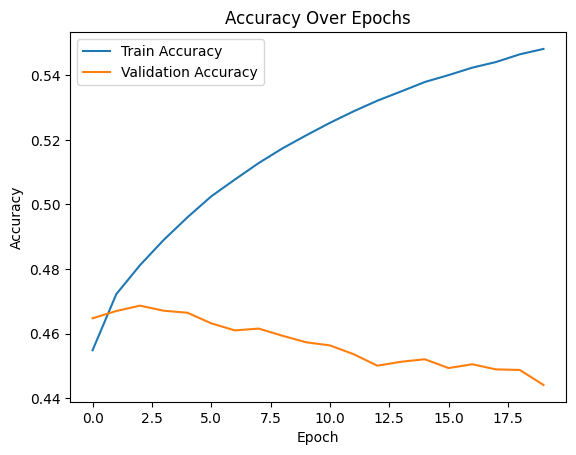

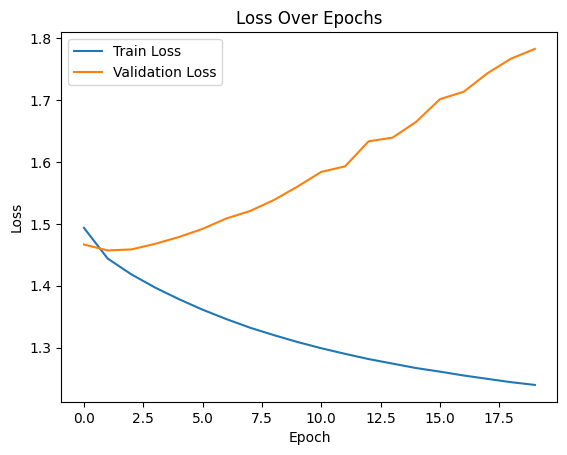

In [ ]:
# plot accuracy curve
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plot loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()